In [1]:
import os
import sys
import gc; gc.enable()
import warnings; warnings.filterwarnings("ignore")

import pickle
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
from tabulate import tabulate
from matplotlib import pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
#from torch.utils.data import Dataset, DataLoader

import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_max_pool
from torch_geometric.loader import DataLoader

from openbabel import pybel
pybel.ob.obErrorLog.SetOutputLevel(0)

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score

In [2]:
data = pd.read_csv('../data/train.csv', index_col=0)
test = pd.read_csv('../data/test.csv', index_col=0)

## build graphs

In [3]:
from graph_creation_baseline import build_graphs

extra_features_table = pd.read_csv('../atom_features.csv', index_col=0)

data_graphs = build_graphs(np.concatenate([data['Smiles'].values, test['Smiles'].values]),
                           extra_features_table=extra_features_table)
test_graphs = data_graphs[-len(test):]
data_graphs = data_graphs[:-len(test)]
for index in range(len(data_graphs)):
    data_graphs[index].y = int(data['Active'].values[index])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7171/7171 [00:40<00:00, 175.07it/s]


## engine

In [4]:
from utils import *

## model

In [5]:
from models import *

## args

In [6]:
# data split args
n_splits, random_state = 8, 42

# positive objects rebalance args
num_pos_repeats, pos_weight = 1, 12.0

# model args
num_features, width, depth = 68, 128, 2
device = torch.device('cuda:0')

# fit args
batch_size, num_workers = 128, 8
lr, num_epochs = 5e-4, 64

# name for logs and checkpoints
name = 'test'

## train

In [7]:
thrs, f1s = [], []
for index in range(n_splits):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    tmp = cv.split(data['Smiles'].values, data['Active'].values.astype(np.int64))

    for _ in range(index + 1):
        train_indices, val_indices = tmp.__next__()

    train_graphs = [data_graphs[index] for index in train_indices if not data_graphs[index].empty]
    val_graphs = [data_graphs[index] for index in val_indices if not data_graphs[index].empty]

    positive_train_graphs = [graph for graph in train_graphs if graph.y]
    if num_pos_repeats > 1:
        train_graphs = train_graphs + positive_train_graphs * (num_pos_repeats - 1)

    train_loader = DataLoader(train_graphs, shuffle=True, batch_size=batch_size, num_workers=num_workers)
    val_loader = DataLoader(val_graphs, shuffle=False, batch_size=batch_size, num_workers=num_workers)
    test_loader = DataLoader(test_graphs, shuffle=False, batch_size=batch_size, num_workers=num_workers)

    model = GCN(num_features, width=width, depth=depth)  # <- GCN defined in models.py, feel free to add more
    model.to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr)

    exp_name = name + '_' + str(index) + '_cv_split'
    
    # trainer defined in utils.py
    trainer = Trainer(model, opt, None, train_loader, val_loader, num_epochs,
                      weight=pos_weight, step='step', backup_by='all',
                      logs_path='./logs', path_to_save='./ckpt', exp_name=exp_name, verbose=0)
    trainer.run()

    thrs.append(trainer.thr)
    f1s.append(trainer.adaptive_f1s[trainer.best_epoch - 1])

# raise Exception('done!')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [02:23<00:00,  2.25s/it]


In [8]:
# ckeckpoints for each launch for each epoch
!ls ./ckpt

test_0_cv_split_1.pth	test_2_cv_split_49.pth	test_5_cv_split_3.pth
test_0_cv_split_10.pth	test_2_cv_split_5.pth	test_5_cv_split_30.pth
test_0_cv_split_11.pth	test_2_cv_split_50.pth	test_5_cv_split_31.pth
test_0_cv_split_12.pth	test_2_cv_split_51.pth	test_5_cv_split_32.pth
test_0_cv_split_13.pth	test_2_cv_split_52.pth	test_5_cv_split_33.pth
test_0_cv_split_14.pth	test_2_cv_split_53.pth	test_5_cv_split_34.pth
test_0_cv_split_15.pth	test_2_cv_split_54.pth	test_5_cv_split_35.pth
test_0_cv_split_16.pth	test_2_cv_split_55.pth	test_5_cv_split_36.pth
test_0_cv_split_17.pth	test_2_cv_split_56.pth	test_5_cv_split_37.pth
test_0_cv_split_18.pth	test_2_cv_split_57.pth	test_5_cv_split_38.pth
test_0_cv_split_19.pth	test_2_cv_split_58.pth	test_5_cv_split_39.pth
test_0_cv_split_2.pth	test_2_cv_split_59.pth	test_5_cv_split_4.pth
test_0_cv_split_20.pth	test_2_cv_split_6.pth	test_5_cv_split_40.pth
test_0_cv_split_21.pth	test_2_cv_split_60.pth	test_5_cv_split_41.pth
test_0_cv_split_22.pth	test_2_cv_split_6

In [9]:
# tensorboard logs folders for each launch
!ls ./logs

test_0_cv_split  test_2_cv_split  test_4_cv_split  test_6_cv_split
test_1_cv_split  test_3_cv_split  test_5_cv_split  test_7_cv_split


## inference

In [10]:
model = GCN(num_features, width=width, depth=depth)
model.to(device)
test_loader = DataLoader(test_graphs, shuffle=False, batch_size=batch_size, num_workers=num_workers)
    
outputs_list = []

# it's best to select ckeckpoints manually based on tensorboard logs
# but lets just take the last one for each launch
selection_dict = {(42, 0): (0, 64),
                  (42, 1): (0, 64),
                  (42, 2): (0, 64),
                  (42, 3): (0, 64),
                  (42, 4): (0, 64),
                  (42, 5): (0, 64),
                  (42, 6): (0, 64),
                  (42, 7): (0, 64)}

outputs_list = []
for index in tqdm(range(n_splits)):
    jndex, epoch = selection_dict[(random_state, index)]
    exp_name = name + '_' + str(index) + '_cv_split' + '_' + str(epoch) + '.pth'
    model.load_state_dict(torch.load(os.path.join('./ckpt', exp_name)))
    
    # inference defined in utils.py
    outputs = inference(model, test_loader)
    outputs_list.append(outputs)
    
outputs_list = np.asarray(outputs_list)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.22it/s]


## submission

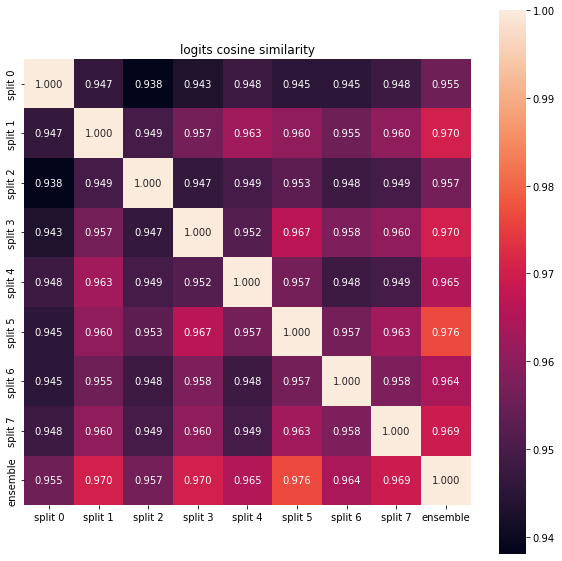

In [11]:
tmp = outputs_list.copy()
tmp = np.vstack([tmp, np.mean(outputs_list, axis=0)[None]])
tmp = 1.0 / (1.0 + np.exp(-tmp))
for index in range(len(tmp)):
    indices = np.argsort(tmp[index])[::-1][:57]
    tmp[index] *= 0.0
    tmp[index, indices] = 1.0

corrs = np.zeros((len(tmp), len(tmp)), dtype=np.float)
for index in range(len(tmp)):
    for jndex in range(index, len(tmp)):
        corrs[index, jndex] = corrs[jndex, index] = np.mean(tmp[index] == tmp[jndex])
        
plt.figure(figsize=(10, 10))
labels = ['split ' + str(index) for index in range(n_splits)] + ['ensemble']
sns.heatmap(corrs, xticklabels=labels, yticklabels=labels, square=True, annot=True, fmt='.3f')
plt.title('logits cosine similarity')
plt.show()

In [12]:
probs = 1.0 / (1.0 + np.exp(-np.mean(outputs_list, axis=0)))
test['Active'] = False
pos_labels = np.argsort(probs)[::-1][0:58]
test['Active'][pos_labels] = True
# test['Active'].values[1495] = False  # <- manually fix some answers?

# test f1=0.4348
test['Active'].to_csv('submission.csv')
test['Active']

0       False
1       False
2        True
3       False
4       False
        ...  
1609    False
1610    False
1611    False
1612    False
1613    False
Name: Active, Length: 1614, dtype: bool